# Order & Return Analysis
## Objective:
Determine the return rate for orders during a given time period and provide any conlusions if possible.

Note:

1. Metrics are organized by months

2. The data covers orders placed in the period of August - December 2016

3. The data is current as of January 28, 2017

First, any necssary libraries are loaded for the analysis. I'm using pandas because it provides a better platform to manipulate the data, including the ability to read the CSV file directly into a dataframe as opposed to working with a list of lists. A preview of the raw data is shown with the first 10 rows.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_excel('XLS_takehome_NA_(1)_(1).xlsx')
data.head(10)

,dateordered,datereturned,orderstatus,orders
0,2016-12-31,2017-01-24,returned,1
1,2016-12-31,NaT,complete,8
2,2016-12-30,NaT,complete,14
3,2016-12-29,NaT,complete,14
4,2016-12-28,2016-12-29,returned,1
5,2016-12-28,NaT,complete,23
6,2016-12-27,2017-01-28,returned,1
7,2016-12-27,2017-01-25,returned,1
8,2016-12-27,2017-01-15,returned,1
9,2016-12-27,2017-01-05,returned,1


## Date Conversion
Since metrics are to be measured by months, it was important to assign a month value to each of the order entries. The timestamps for both completed and returned orders contained the month in which the order was made but it did not allow for convenient subsetting of the data.  

The function `date_convert` reads the timestamp value found in the `dateordered` and `datereturned` columns. It parses out the numerical month value and converts it to a string of the month's full name. The corresponding months are then appended to the dataframe in new columns labeled `monthordered` and `monthreturned`. Any `NaT` values are changed to a `None` value in the `monthreturned` column

In [2]:
def date_convert(x):
    if pd.isnull(x) is False:
        order_month = dt.datetime.strptime(str(x.month),'%m')
        order_month = order_month.strftime('%B')
    else:
        return None
    return order_month
    
data['monthordered'] = data['dateordered'].apply(date_convert)
data['monthreturned'] = data['datereturned'].apply(date_convert)
data.head(10)

,dateordered,datereturned,orderstatus,orders,monthordered,monthreturned
0,2016-12-31,2017-01-24,returned,1,December,January
1,2016-12-31,NaT,complete,8,December,None
2,2016-12-30,NaT,complete,14,December,None
3,2016-12-29,NaT,complete,14,December,None
4,2016-12-28,2016-12-29,returned,1,December,December
5,2016-12-28,NaT,complete,23,December,None
6,2016-12-27,2017-01-28,returned,1,December,January
7,2016-12-27,2017-01-25,returned,1,December,January
8,2016-12-27,2017-01-15,returned,1,December,January
9,2016-12-27,2017-01-05,returned,1,December,January


## Data Processing:
### Formatting the data
In order to understand how the return rate changed over the given time period, the data needs to be filtered and analyzed. I use the pivot table features from pandas because it allows for most flexibility and applying calculations to subsets of the data. If I weren't to use pandas and pivot tables, the following code is an example of how I would calculate the total returns for each month based on the order month. It returns a dictionary with the months as keys and total returns as values: 

In [3]:
months = ['August',
          'September',
          'October',
          'November',
          'December',]
returns_by_month = {}
for month in months:
    mth = data[(data['monthordered'] == month) & (data['orderstatus'] == 'returned')]
    rtrn = mth['orders']
    returns_by_month[month] = rtrn.sum()
returns_by_month

{'August': 10, 'December': 19, 'November': 12, 'October': 10, 'September': 9}

The pivot table below helps to break down total number of returns and completed orders for each month. This dataframe gives a little more insight into how the return orders changed relative to the total amount. 

In [4]:
data_returns_rate = data.pivot_table(index = ['monthordered','orderstatus'],
                                     values=['orders'],
                                     aggfunc= np.sum)
data_returns_rate = data_returns_rate.reindex(['August',
                                               'September',
                                               'October',
                                               'November',
                                               'December',
                                               'January'],level=0)

In [5]:
data_returns_rate

orders
monthordered orderstatus        
August       complete        139
             returned         10
September    complete        134
             returned          9
October      complete        170
             returned         10
November     complete        214
             returned         12
December     complete        376
             returned         19

### Calculating the return rate per month
The return rate for each month can be determined by finding the ratio between the returns in a month based off the order date and the sum total of these returns and the completed orders for that month. Since there is no order data for January, it is not included in the calculations. The function `return_rate` calculates this for each month and returns the rate as a percentage.

In [6]:
def return_rate(x):
    index = 0
    total = pd.Series()
    for row in range(0,int(len(x)/2)):
        rate = (x.iloc[index+1]/(x.iloc[index+1]+x.iloc[index]))*100
        index += 2
        total.set_value(row,rate)
    return total

total_returns_rate = data_returns_rate.apply(return_rate)
total_returns_rate = total_returns_rate.rename(index={0:'August',
                                                      1:'September',
                                                      2:'October',
                                                      3:'November',
                                                      4:'December'},
                                               columns={'orders':'Return Rate (%)'})

In [7]:
total_returns_rate

,Return Rate (%)
August,6.711409
September,6.293706
October,5.555556
November,5.309735
December,4.810127


## Findings:
The chart below shows the return rate has exhibited a decreasing trend for each month between Aug.'16 to Dec.'16. On average, the return rate is decreasing at .47% per month with the largest drop of .75% occurring between September and October. Although this data only represents 5 months out of the year, the decreasing trend is possibly indicative of customers becoming more comfortable with the product as they have more time to experience it.

(0, 8)

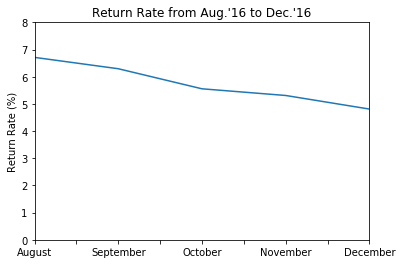

In [8]:
ax1 = total_returns_rate.plot(legend=False)
ax1.set_ylabel('Return Rate (%)')
ax1.set_title('Return Rate from Aug.\'16 to Dec.\'16')
ax1.set_ylim(0,8)

In addition to calculating the return rate, I was curious about understanding some other characteristics of the data. Namely, how long a customer waited before initiating a return and which months possessed the most returns. The histogram shows a collection of the number of days that customers spent with the product before initiating a return. Since customers have 100 days before they can receive a full refund, we would expect the bulk of the data to be less than this limit. The chart shows that a majority of the customers spent less than 60 days with the product before initiating a return. 

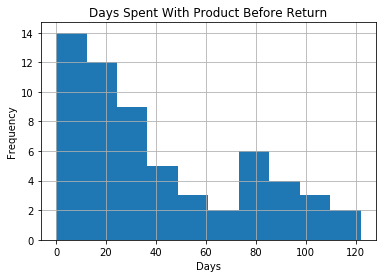

In [9]:
returns = data[data['orderstatus'] == 'returned']
returns_length = ((returns['datereturned']-returns['dateordered'])/np.timedelta64(1, 'D')).astype(int)

ax2 = returns_length.hist(bins = 10)
ax2.set_xlabel('Days')
ax2.set_ylabel('Frequency')
ax2.set_title('Days Spent With Product Before Return')

Finally, I wanted to look at how both the returns and completed orders changed for each month. The chart below shows that while the number of returns grew at approximately 3.2 returns/month, completed orders increased at nearly 13 times that rate with 61.5 orders/month. It can be inferred that this increase--potentially influenced by the holiday shopping season-- is the cause for the increased number of returns during the given time period. 

In [10]:
returns_table = data.pivot_table(index = ['monthreturned'],
                                 values=['orders'],
                                 aggfunc= np.sum)
returns_table = returns_table.reindex(['August',
                                       'September',
                                       'October',
                                       'November',
                                       'December',
                                       'January'])
completes = data[data['orderstatus'] == 'complete']
completes_table = data.pivot_table(index = ['monthordered'],
                                   values=['orders'],
                                   aggfunc= np.sum)

completes_table = completes_table.reindex(['August',
                                           'September',
                                           'October',
                                           'November',
                                           'December',
                                           'January'])

In [11]:
returns_table

,orders
monthreturned,
August,1
September,2
October,8
November,13
December,19
January,17


In [12]:
completes_table

,orders
monthordered,
August,149.0
September,143.0
October,180.0
November,226.0
December,395.0
January,NaN


In [13]:
# Calculations for determining returns the rate of change
(returns_table.iloc[-1]-returns_table.iloc[0])/(returns_table.shape[0]-1)

orders    3.2
dtype: float64

In [14]:
# Calculations for determining the completed orders rate of change
(completes_table.iloc[-2]-completes_table.iloc[0])/(completes_table.shape[0]-2)

orders    61.5
dtype: float64

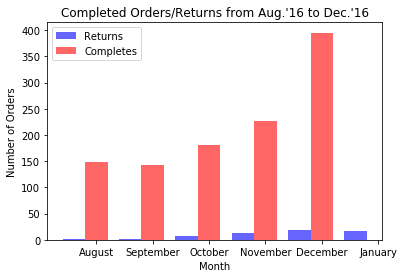

In [15]:
n_groups = 6
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.6

returns_bar = plt.bar(index, 
                      returns_table['orders'][:6],
                      bar_width,
                      alpha=opacity,
                      color='b',
                      label='Returns')

completes_bar = plt.bar(index + bar_width,
                        completes_table['orders'][:6],
                        bar_width,
                        alpha=opacity,
                        color='r',
                        label='Completes')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Completed Orders/Returns from Aug.\'16 to Dec.\'16')
plt.xticks(index + bar_width, ('August',
                               'September',
                               'October',
                               'November',
                               'December',
                               'January'))
plt.legend()
plt.show()